# Neural Networks for Data Science Applications
## Final Homework: Putting everything together

**Name**: Simone Marretta

**Matricola**: 1911358

Send the completed notebook before 15-01-2021 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_2_\<id\>".

**Overview**: The homework is composed of four parts: (i) select a dataset; (ii) implement a custom component (ONLY if you did not submit the first homework); (iii) implement a neural network and train it on the dataset; (iv) perform a post-training operation on the method (interpretation / robustness / fairness).

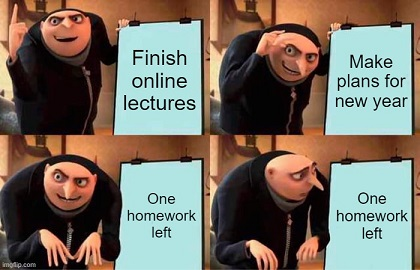

In [1]:
import tensorflow as tf

**Important - before starting**: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*.

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts)... The task can be either classification or a more complex task (e.g., segmentation, sequence prediction, ...). *For tasks beyond classification, check carefully that the final exercise is viable before starting your implementation.*

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark, so you can select a complexity that you believe adequate to your skills.

**DESCRIPTION OF THE CODE**: *Provide a small description of the dataset here (e.g., source, task, bibliographic reference if necessary...).*

I used the Stanford Dogs dataset from Tensorflow datasets(https://www.tensorflow.org/datasets/catalog/stanford_dogs)

Original source: http://vision.stanford.edu/aditya86/ImageNetDogs/main.html


It can be used for image classification.
It's composed by 20580 images(12000 are used for the training set) and it contains images of 120 breeds of dogs from all over the world.

In [2]:
#Importing dataset from tensorflow datasets
import tensorflow_datasets as tfds
_,info = tfds.load(
    name='stanford_dogs',with_info=True)
dogs_train, dogs_validation, dogs_test= tfds.load(
    name='stanford_dogs',
    split=[
        'train[:80%]',            
        'train[80%:]',
        'test'
    ],
    as_supervised=True,
    shuffle_files=True,
) 
print(info)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

### Exercise 2: Train on your data (5 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. If you did Exercise 1, **include your custom component here**. Otherwise, you are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

**DESCRIPTION OF THE CODE**: *Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

The task is to classify the images in the correct class.So it's an image classification task.
I first tried to use a CNN from scratch.It has an architecture with 3 convolutional layers with filters of size 32,64 and 128.
I added also Dropout and Maxpooling layers to help with overfitting and robustness.
At the end I attached some dense layers to perform classification.

The model didn't work and I try using a transfer learning technique.


I picked a InceptionResNetV2 network pretrained on the Imagenet dataset and I trained the classifier layer after adding a GlobalAveragePooling2d and a Dropout layer.
This approach worked.

In [3]:
#Define preprocessing and augmentation functions
def preprocess(image, label):
    image = tf.image.resize(image, [224,224])
    image = image/255.0
    return image, tf.cast(label, tf.float32)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label    

In [4]:
train_data = dogs_train.shuffle(1000).map(preprocess).map(augment).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
validation_data = dogs_validation.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_data = dogs_test.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(120, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [6]:
model.compile(optimizer=keras.optimizers.SGD(nesterov=True), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [7]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss',
restore_best_weights=True)
model.fit(
    train_data, epochs=100, validation_data=validation_data, callbacks = [early_stopping_cb])

Epoch 1/100
300/300 [==============================] - 21s 62ms/step - loss: 4.7956 - sparse_categorical_accuracy: 0.0082 - val_loss: 4.7881 - val_sparse_categorical_accuracy: 0.0096
Epoch 2/100
300/300 [==============================] - 19s 62ms/step - loss: 4.7871 - sparse_categorical_accuracy: 0.0110 - val_loss: 4.7871 - val_sparse_categorical_accuracy: 0.0096
Epoch 3/100
300/300 [==============================] - 19s 61ms/step - loss: 4.7851 - sparse_categorical_accuracy: 0.0096 - val_loss: 4.7863 - val_sparse_categorical_accuracy: 0.0146
Epoch 4/100
300/300 [==============================] - 19s 61ms/step - loss: 4.7835 - sparse_categorical_accuracy: 0.0121 - val_loss: 4.7864 - val_sparse_categorical_accuracy: 0.0113
Epoch 5/100
300/300 [==============================] - 19s 61ms/step - loss: 4.7817 - sparse_categorical_accuracy: 0.0092 - val_loss: 4.7845 - val_sparse_categorical_accuracy: 0.0150
Epoch 6/100
300/300 [==============================] - 19s 61ms/step - loss: 4.7785 -

In [8]:
model.evaluate(test_data)

269/269 [==============================] - 11s 40ms/step - loss: 3.9074 - sparse_categorical_accuracy: 0.1258


[3.9073972702026367, 0.12575757503509521]

We see that the accuracy is really low,the model doesn't work because we have few training examples and the classes are 120.
We'll try with transfer learning and in particular with the InceptionResNetV2 trained on Imagenet dataset

In [9]:
import keras
base_model = keras.applications.InceptionResNetV2(input_shape=(224,224,3),weights="imagenet",
include_top=False)
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(120, activation='softmax')
])




In [10]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(nesterov=True),
metrics=["sparse_categorical_accuracy"])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss',
restore_best_weights=True)
history = model.fit(train_data, epochs=100, validation_data=validation_data,callbacks=[early_stopping_cb])

Epoch 1/100
300/300 [==============================] - 55s 146ms/step - loss: 3.5301 - sparse_categorical_accuracy: 0.3504 - val_loss: 0.9121 - val_sparse_categorical_accuracy: 0.8325
Epoch 2/100
300/300 [==============================] - 41s 135ms/step - loss: 0.7845 - sparse_categorical_accuracy: 0.8314 - val_loss: 0.6154 - val_sparse_categorical_accuracy: 0.8421
Epoch 3/100
300/300 [==============================] - 41s 135ms/step - loss: 0.5929 - sparse_categorical_accuracy: 0.8399 - val_loss: 0.5545 - val_sparse_categorical_accuracy: 0.8496
Epoch 4/100
300/300 [==============================] - 41s 135ms/step - loss: 0.5330 - sparse_categorical_accuracy: 0.8443 - val_loss: 0.5316 - val_sparse_categorical_accuracy: 0.8471
Epoch 5/100
300/300 [==============================] - 41s 135ms/step - loss: 0.4899 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.5171 - val_sparse_categorical_accuracy: 0.8500
Epoch 6/100
300/300 [==============================] - 41s 135ms/step - loss: 0.

In [11]:
model.evaluate(test_data)

269/269 [==============================] - 29s 108ms/step - loss: 0.5049 - sparse_categorical_accuracy: 0.8536


[0.5048738121986389, 0.8536130785942078]

### Exercise 3 (5 points)

Training a model is only the beginning! Select **one of the three** paths below, and follow the instructions.

1. **Interpreting your model**: interpretability is critical in many applications. Good libraries for obtaining interpetations from your model are [tf-explain](https://github.com/sicara/tf-explain), the original [LIME implementation](https://github.com/marcotcr/lime), and IBM [AIX360 Toolbox](https://github.com/Trusted-AI/AIX360). For this path, select an interpretability method, *read carefully the original paper*, and test it on one of your input examples. You can use one of the basic methods seen in the course, or a more advanced variant (e.g., Gradients*Input, Integrated Gradients, ...).

2. **Attacking your model**: there are a number of libraries for crafting an adversarial attack. Possible alternatives are [CleverHans](https://github.com/tensorflow/cleverhans), [Foolbox](https://github.com/bethgelab/foolbox), or the [Adversarial Robustness Toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox). Select one white-box adversarial attack, *read carefully the original paper*, and create an adversarial attack on your network. You can use FGSM as seen in the course, or a more advanced method (e.g., JSMA, ...).

3. **Fairness**: finally, you might want to evaluate whether your model is fair. Good libraries for this are [FAT Forensics](https://fat-forensics.org/) or IBM [AIF360 Toolbox](https://github.com/Trusted-AI/AIF360). For this exercise, select a fairness metric, and evaluate the group fairness on your dataset. Then, apply a post-processing to enforce the fairness, and evaluate the eventual variation in accuracy.

For this part I chose to use the Cleverhans library.
It's an open-source library for benchmarking the vulnerability of machine learning models to adversarial examples.
It was created by Ian Goodfellow and Nicolas Papernot.
I chose to use directly the Github repository of the library because the current version doesn't support TF2 but on github there is already the code supporting TF2.

I used the Fast gradient sign method.
It's an adversarial attack that uses the gradient of the loss and it adjusts the inputs in order to maximize the loss.
In other words the original image x is manipulated by adding or subtracting a small error ϵ to each pixel.We add ϵ if the sign of the gradient for a pixel is positive otherwise we subtract ϵ .So we obtain that the image is intentionally altered to make the model classification fail.

In [12]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method


logits_model = tf.keras.Model(model.input,model.layers[-1].output)

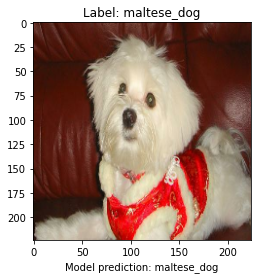

In [23]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
 
test_x,test_y=next(iter(test_data))
get_name = info.features['label'].int2str
random_index = np.random.randint(test_x.shape[0])

original_image = test_x[random_index]
original_image = tf.image.resize(original_image, [224,224])
original_image = np.reshape(original_image,(1,224,224,3))

original_label = test_y[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64')
#Show the image
plt.figure()


plt.imshow(np.reshape(original_image,(224,224,3)))
plt.title("Label: {}".format(str(get_name(original_label[0])).split("-")[1]))
plt.xlabel("Model prediction: {}".format(str(get_name(np.argmax(model.predict(original_image)))).split("-")[1]))

plt.show()


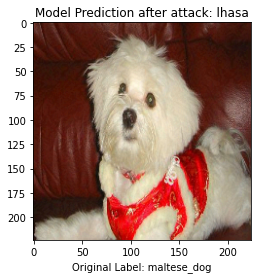

In [22]:
epsilon = 0.01


adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (224,224,3)))
plt.title("Model Prediction after attack: {}".format(str(get_name(np.argmax(adv_example_untargeted_label_pred)).split("-")[1])))
plt.xlabel("Original Label: {}".format(str(get_name(np.argmax(model.predict(original_image)))).split("-")[1]))

plt.show()

In [15]:
epsilon = 0.01

adv_batch_attacked = fast_gradient_method(logits_model, test_x, epsilon, np.inf, targeted=False)
adv_batch_predicted = np.argmax(model.predict(adv_batch_attacked),axis = 1)
preds_first = np.argmax(model.predict(test_x),axis=1)
print('test acc on FGM adversarial examples (%): {:.3f}'.format(np.sum(test_y == adv_batch_predicted)/len(test_y) * 100))
print('test acc on clean examples (%): {:.3f}'.format(np.sum(test_y == preds_first)/len(test_y) * 100))

test acc on FGM adversarial examples (%): 21.875
test acc on clean examples (%): 93.750


### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook before 15-01-2021 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_2_\<id\>".

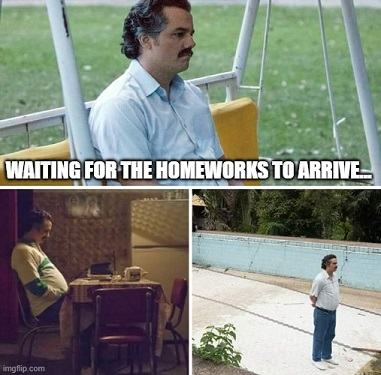